In [ ]:
import os

os.environ["KERAS_BACKEND"] = "jax"  # @param ["tensorflow", "jax", "torch"]

import keras
from keras import layers
from keras import ops

import numpy as np
import matplotlib.pyplot as plt

In [13]:
num_classes = 36
input_shape = (200, 200, 3)

In [14]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

def load_images_from_folder(folder_path, target_size=(200, 200)):
    images = []
    labels = []
    class_names = sorted(os.listdir(folder_path))  # Sort for consistency in label indexing
    print(f"Found classes: {class_names}")

    # Initialize LabelEncoder
    label_encoder = LabelEncoder()
    label_encoder.fit(class_names)  # Fit encoder to class names

    for class_name in class_names:
        class_folder = os.path.join(folder_path, class_name)
        if os.path.isdir(class_folder):
            for filename in os.listdir(class_folder):
                image_path = os.path.join(class_folder, filename)
                image = load_img(image_path, target_size=target_size)
                image = img_to_array(image)
                images.append(image)
                labels.append(class_name)  # Append class name as label
        else:
            print(f"Skipping non-folder file: {class_folder}")

    images = np.array(images, dtype=np.float32)  # Convert to numpy array (float32)
    labels = np.array(labels)  # Convert labels to numpy array

    # Encode string labels to integers
    labels = label_encoder.transform(labels)

    return images, labels, label_encoder.classes_

# Example usage:
folder_path = "asl_dataset"  # Main dataset folder with subfolders for each class
images, labels, class_names = load_images_from_folder(folder_path)

# Shuffle images and labels before splitting
images, labels = shuffle(images, labels, random_state=42)

# Optionally, split the dataset into train, validation, and test sets
train_x, test_x, train_y, test_y = train_test_split(images, labels, test_size=0.2, random_state=42)
train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, test_size=0.1, random_state=42)

print(f"Loaded {len(images)} images from {len(class_names)} classes.")
print(f"Train set: {len(train_x)}, Validation set: {len(valid_x)}, Test set: {len(test_x)}")

Found classes: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
Loaded 2515 images from 36 classes.
Train set: 1810, Validation set: 202, Test set: 503


In [15]:
# Create a dictionary to map encoded labels to real class names
label_mapping = {index: class_name for index, class_name in enumerate(class_names)}

# Display the label mappings
print("Label mappings:")
for label, class_name in label_mapping.items():
    print(f"{label}: {class_name}")

Label mappings:
0: 0
1: 1
2: 2
3: 3
4: 4
5: 5
6: 6
7: 7
8: 8
9: 9
10: a
11: b
12: c
13: d
14: e
15: f
16: g
17: h
18: i
19: j
20: k
21: l
22: m
23: n
24: o
25: p
26: q
27: r
28: s
29: t
30: u
31: v
32: w
33: x
34: y
35: z


In [16]:
learning_rate = 0.001
weight_decay = 0.1
batch_size = 256
num_epochs = 50  # For real training, use num_epochs=100. 10 is a test value
image_size = 128  # We'll resize input images to this size
patch_size = 16  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 6
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [
    2048,
    1024
]  # Size of the dense layers of the final classifier


In [17]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(train_x)

In [18]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=keras.activations.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [ ]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        input_shape = ops.shape(images)
        batch_size = input_shape[0]
        height = input_shape[1]
        width = input_shape[2]
        channels = input_shape[3]
        num_patches_h = height // self.patch_size
        num_patches_w = width // self.patch_size
        patches = keras.ops.image.extract_patches(images, size=self.patch_size)
        patches = ops.reshape(
            patches,
            (
                batch_size,
                num_patches_h * num_patches_w,
                self.patch_size * self.patch_size * channels,
            ),
        )
        return patches

    def get_config(self):
        config = super().get_config()
        config.update({"patch_size": self.patch_size})
        return config


Image size: 128 X 128
Patch size: 16 X 16
Patches per image: 64
Elements per patch: 768


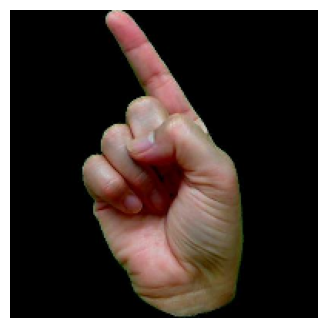

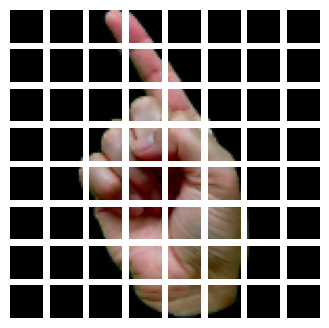

In [20]:
plt.figure(figsize=(4, 4))
image = train_x[np.random.choice(range(train_x.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = ops.image.resize(
    ops.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = ops.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(ops.convert_to_numpy(patch_img).astype("uint8"))
    plt.axis("off")


In [ ]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.projection_dim = projection_dim
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = ops.expand_dims(
            ops.arange(start=0, stop=self.num_patches, step=1), axis=0
        )
        projected_patches = self.projection(patch)
        encoded = projected_patches + self.position_embedding(positions)
        return encoded

    def get_config(self):
        config = super().get_config()
        config.update({
            "num_patches": self.num_patches,
            "projection_dim": self.projection_dim
        })
        return config

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import MultiHeadAttention

class ConvolutionalAdditiveAttention(layers.Layer):
    def __init__(self, projection_dim):
        super(ConvolutionalAdditiveAttention, self).__init__()
        self.projection_dim = projection_dim

        # Define independent linear transformations for Q, K, and V
        self.query_dense = layers.Dense(projection_dim)
        self.key_dense = layers.Dense(projection_dim)
        self.value_dense = layers.Dense(projection_dim)
        
        # Define convolutions for channel and spatial context mapping
        self.channel_conv = layers.Conv1D(filters=projection_dim, kernel_size=1, activation='sigmoid')
        self.spatial_conv = layers.Conv1D(filters=projection_dim, kernel_size=1, activation='sigmoid')

        # Linear transformation Γ for contextual information integration
        self.output_dense = layers.Dense(projection_dim)

    def call(self, inputs):
        # Split inputs into Q, K, V
        q = self.query_dense(inputs)
        k = self.key_dense(inputs)
        v = self.value_dense(inputs)

        # Apply the context mapping Φ as channel and spatial attention
        phi_q = self.channel_conv(q) + self.spatial_conv(q)
        phi_k = self.channel_conv(k) + self.spatial_conv(k)
        
        # Calculate similarity as Φ(Q) + Φ(K)
        similarity = phi_q + phi_k

        # Integrate contextual information and combine with V
        attention_output = self.output_dense(similarity) * v
        return attention_output

# Update model with Convolutional Additive Attention
def create_ConvolutionalAdditiveAttention_vit_classifier():
    inputs = keras.Input(shape=input_shape)
    # Augment data
    augmented = data_augmentation(inputs)
    # Create patches
    patches = Patches(patch_size)(augmented)
    # Encode patches
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block with CATM
    for _ in range(transformer_layers):
        # Layer normalization 1
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Replace Multi-Head Attention with Convolutional Additive Attention (CATM)
        attention_output = ConvolutionalAdditiveAttention(projection_dim)(x1)
        # Skip connection 1
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

def create_traditional_vit_classifier():
    inputs = keras.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [23]:
def run_experiment(model, learning_rate, weight_decay, batch_size, num_epochs):
    # Define optimizer with dynamic learning rate and weight decay
    optimizer = keras.optimizers.AdamW(
        learning_rate=learning_rate,
        weight_decay=weight_decay
    )

    # Compile model with the specified optimizer
    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    # Set up checkpoint to save the best model
    checkpoint_filepath = "/tmp/checkpoint.weights.h5"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    # Fit the model
    history = model.fit(
        x=train_x,
        y=train_y,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    # Load the best weights and evaluate on the test set
    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(test_x, test_y)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history

In [31]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


def count_flops(model):
    flops = 0

    # Calculate the input dimensions based on parameters
    input_channels = 3  # Assuming RGB images
    input_dim = image_size * image_size * input_channels  # Flattened input dimension for images

    for layer in model.layers:
        if isinstance(layer, layers.Conv2D):
            # FLOPs for Conv2D: (kernel_height * kernel_width * input_channels + 1) * output_height * output_width * output_channels
            if layer.input_shape:
                flops += (layer.kernel_size[0] * layer.kernel_size[1] * layer.input_shape[-1] + 1) * \
                          layer.output_shape[1] * layer.output_shape[2] * layer.filters
            
        elif isinstance(layer, layers.Dense):
            # FLOPs for Dense: (input_features + 1) * output_features
            flops += (input_dim + 1) * layer.units
            input_dim = layer.units  # Update input_dim for next layer
            
        elif isinstance(layer, layers.MultiHeadAttention):
            # Calculate FLOPs for MultiHeadAttention
            key_dim = projection_dim // num_heads  # Adjusting key dimension based on number of heads
            
            # FLOPs for Q, K, V projections
            flops += 3 * (input_dim * projection_dim)  # Q, K, V projections
            
            # FLOPs for dot products to calculate attention scores
            flops += num_heads * (input_dim * key_dim)  # Each head's Q.K^T
            flops += num_heads * (key_dim * input_dim)  # Each head's attention weighting with V
            
            # Self-attention operation
            flops += 2 * (num_heads * key_dim * input_dim)  # Attention computation (weighting V)
            
            # Output dense layer
            flops += (projection_dim + 1) * input_dim  # Dense layer after attention
            input_dim = projection_dim  # Update input_dim after MultiHeadAttention

            
        elif isinstance(layer, ConvolutionalAdditiveAttention):
            # Calculate FLOPs for Convolutional Additive Attention
            # Q, K, V projections
            flops += 3 * (input_dim + 1) * layer.projection_dim  # Q, K, V projections
            # Channel and spatial context convolutions
            flops += 2 * (2 * input_dim * layer.projection_dim)  # 2 convolutions each of 1x1 convolution
            # Output dense layer
            flops += (layer.projection_dim + 1) * layer.projection_dim  # Output dense layer
            input_dim = layer.projection_dim  # Update input_dim


    return flops

# Example usage
mha_model = create_traditional_vit_classifier()  # Create your traditional ViT model
mha_model.build(input_shape=(None, image_size, image_size, 3))  # Provide the correct input shape

cat_model = create_ConvolutionalAdditiveAttention_vit_classifier()  # Create your CATM model
cat_model.build(input_shape=(None, image_size, image_size, 3))  # Provide the correct input shape

mha_flops_count = count_flops(mha_model)
cat_flops_count = count_flops(cat_model)

print(f"Total FLOPs for traditional ViT model: {mha_flops_count}")
print(f"Total FLOPs for Convolutional Additive Attention model: {cat_flops_count}")

Total FLOPs for traditional ViT model: 27052004
Total FLOPs for Convolutional Additive Attention model: 24656420


In [14]:
def plot_comparison(results, metric="loss"):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    for result in results:
        lr, wd, bs, pd = result["params"]
        label = f"LR={lr}, WD={wd}, BS={bs}, PD={pd}"
        
        # Plot training and validation metrics
        axes[0].plot(result["history"].history[metric], label=f"{label} Train")
        axes[1].plot(result["history"].history[f"val_{metric}"], label=f"{label} Val")
    
    # Set labels and titles
    axes[0].set_title(f"Training {metric.capitalize()} Over Epochs")
    axes[0].set_xlabel("Epochs")
    axes[0].set_ylabel(metric.capitalize())
    axes[1].set_title(f"Validation {metric.capitalize()} Over Epochs")
    axes[1].set_xlabel("Epochs")
    axes[1].set_ylabel(metric.capitalize())
    
    for ax in axes:
        ax.legend()
        ax.grid()

    plt.tight_layout()
    plt.show()

Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 74s 6s/step - accuracy: 0.0621 - loss: 5.1348 - top-5-accuracy: 0.2180 - val_accuracy: 0.3702 - val_loss: 2.4165 - val_top-5-accuracy: 0.6685
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 92s 7s/step - accuracy: 0.1754 - loss: 3.1149 - top-5-accuracy: 0.4703 - val_accuracy: 0.4807 - val_loss: 1.9235 - val_top-5-accuracy: 0.8232
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 84s 6s/step - accuracy: 0.2856 - loss: 2.4937 - top-5-accuracy: 0.6572 - val_accuracy: 0.5138 - val_loss: 1.5818 - val_top-5-accuracy: 0.8950
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 55s 4s/step - accuracy: 0.3218 - loss: 2.2244 - top-5-accuracy: 0.7274 - val_accuracy: 0.6575 - val_loss: 1.2817 - val_top-5-accuracy: 0.9392
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 56s 4s/step - accuracy: 0.3945 - loss: 1.8847 - top-5-accuracy: 0.8150 - val_accuracy: 0.7293 - val_loss: 1.0567 - val_top-5-accuracy: 0.9613
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 57s 4s/step - accuracy: 0.4469 - loss: 1.7383 - top-5-accuracy

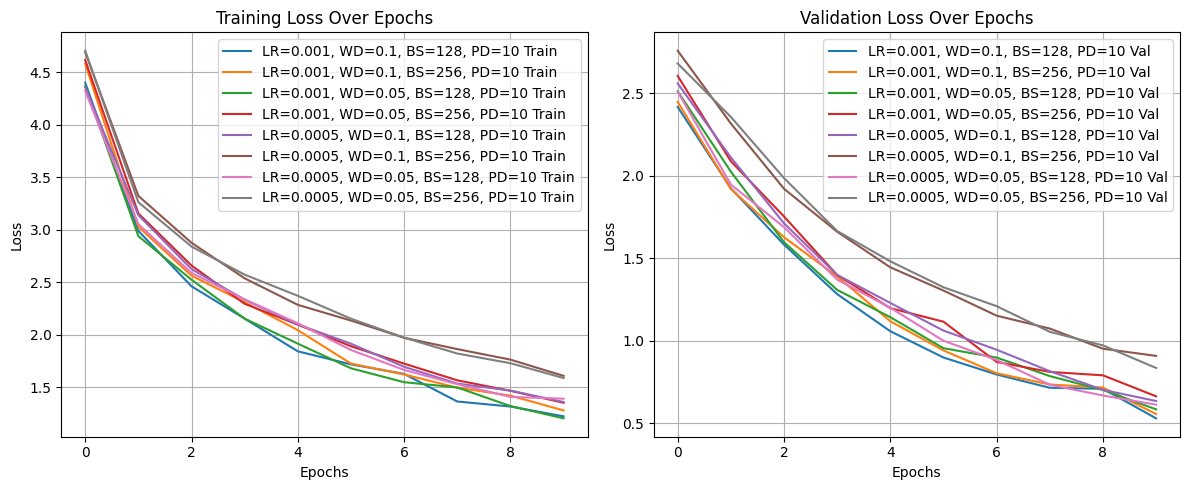

In [34]:
import time

# Define hyperparameter ranges
learning_rates = [0.001, 0.0005]
weight_decays = [0.1, 0.05]
batch_sizes = [128, 256]
epoch_options = [10]

# Store results for comparison
results = []

for lr in learning_rates:
    for wd in weight_decays:
        for bs in batch_sizes:
            for num_epochs in epoch_options:
                # Initialize model
                vit_traditional_classifier = create_traditional_vit_classifier()
                
                # Measure start time
                start_time = time.time()
                
                # Run experiment
                history = run_experiment(
                    vit_traditional_classifier,
                    learning_rate=lr,
                    weight_decay=wd,
                    batch_size=bs,
                    num_epochs=num_epochs
                )
                
                # Measure end time and calculate runtime
                end_time = time.time()
                runtime = end_time - start_time
                
                # Collect results
                results.append({
                    "params": (lr, wd, bs, num_epochs),
                    "history": history,
                    "runtime": runtime
                })

# Example of how to plot results with runtime
plot_comparison(results, "loss")  # Replace "loss" with other metrics as needed

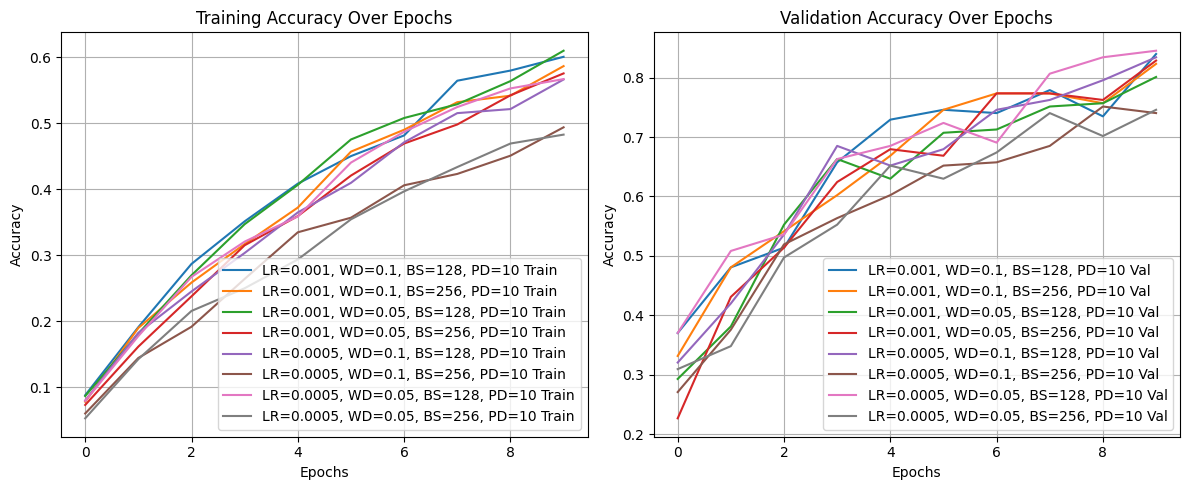

In [35]:
plot_comparison(results, "accuracy")  # Replace "loss" with other metrics as needed

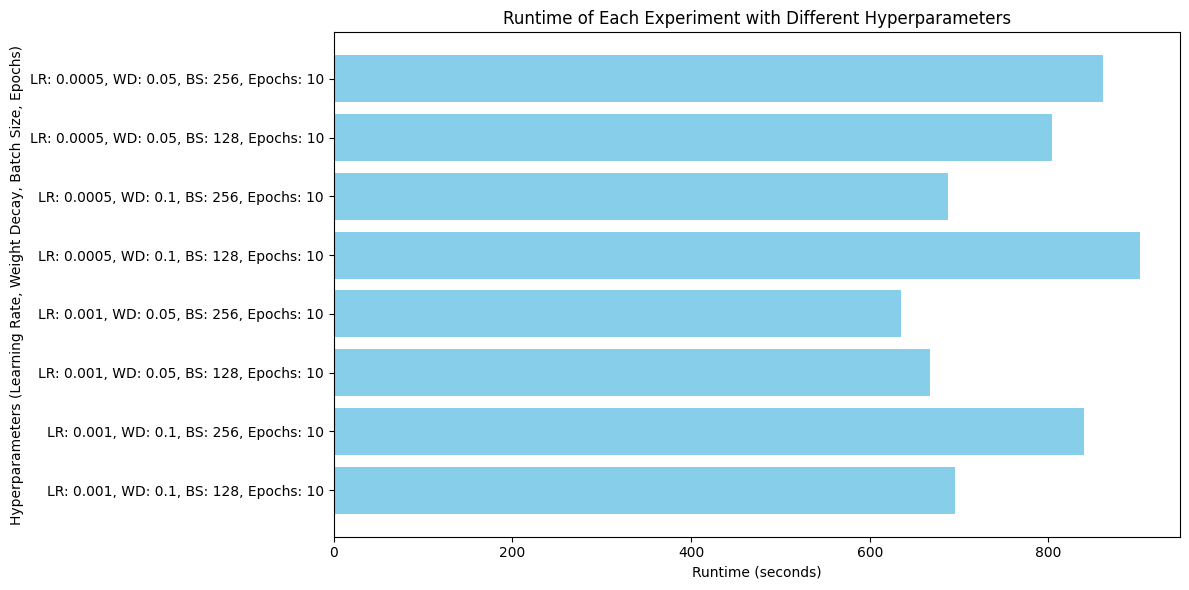

In [37]:
import matplotlib.pyplot as plt

# Extract parameters and runtimes from results
params = [f"LR: {r['params'][0]}, WD: {r['params'][1]}, BS: {r['params'][2]}, Epochs: {r['params'][3]}"
          for r in results]
runtimes = [r['runtime'] for r in results]

# Create a bar plot for runtime
plt.figure(figsize=(12, 6))
plt.barh(params, runtimes, color='skyblue')
plt.xlabel("Runtime (seconds)")
plt.ylabel("Hyperparameters (Learning Rate, Weight Decay, Batch Size, Epochs)")
plt.title("Runtime of Each Experiment with Different Hyperparameters")
plt.tight_layout()
plt.show()

Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 64s 9s/step - accuracy: 0.0498 - loss: 5.1946 - top-5-accuracy: 0.2078 - val_accuracy: 0.3204 - val_loss: 2.5686 - val_top-5-accuracy: 0.7017
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 93s 12s/step - accuracy: 0.1680 - loss: 3.1523 - top-5-accuracy: 0.4662 - val_accuracy: 0.4696 - val_loss: 2.0656 - val_top-5-accuracy: 0.7790
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 58s 8s/step - accuracy: 0.2301 - loss: 2.6805 - top-5-accuracy: 0.6053 - val_accuracy: 0.5138 - val_loss: 1.7249 - val_top-5-accuracy: 0.8785
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 57s 8s/step - accuracy: 0.2812 - loss: 2.4155 - top-5-accuracy: 0.6678 - val_accuracy: 0.5967 - val_loss: 1.4668 - val_top-5-accuracy: 0.9227
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 64s 9s/step - accuracy: 0.3494 - loss: 2.1598 - top-5-accuracy: 0.7531 - val_accuracy: 0.6575 - val_loss: 1.2250 - val_top-5-accuracy: 0.9558
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 61s 9s/step - accuracy: 0.4112 - loss: 1.9382 - top-5-accuracy: 0.8021 - 

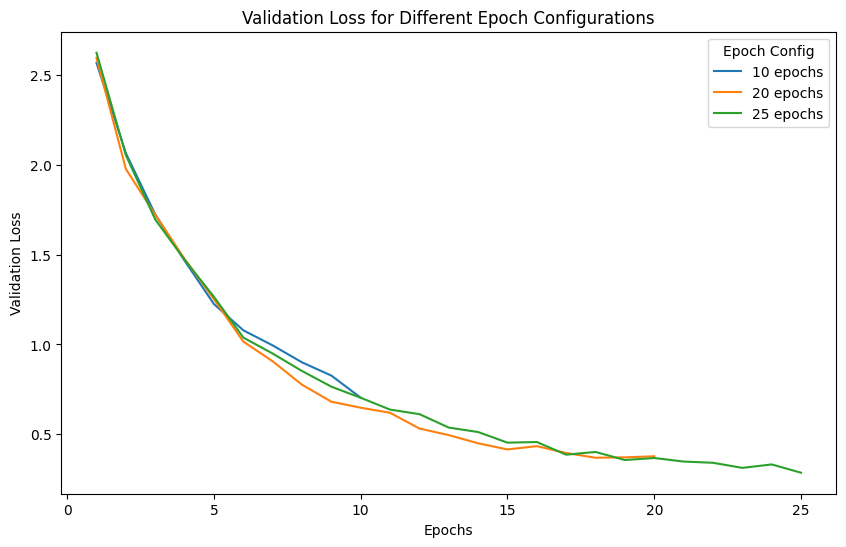

In [80]:
import time
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
import keras

# Fixed best hyperparameters from prior experiment
best_learning_rate = 0.001
best_weight_decay = 0.1
best_batch_size = 256

# Define varying epoch options to evaluate
epoch_options = [ 10, 20, 25]

# Store results for each epoch configuration
epoch_results = []

for num_epochs in epoch_options:
    # Initialize model
    vit_traditional_classifier = create_traditional_vit_classifier()
    
    # Measure start time
    start_time = time.time()
    
    # Run experiment with early stopping and fixed parameters
    early_stopping = EarlyStopping(
        monitor="val_loss",
        patience=3,
        restore_best_weights=True
    )
    
    # Run experiment and capture history
    history = run_experiment(
        vit_traditional_classifier,
        learning_rate=best_learning_rate,
        weight_decay=best_weight_decay,
        batch_size=best_batch_size,
        num_epochs=num_epochs
    )
    
    # Measure end time and calculate runtime
    end_time = time.time()
    runtime = end_time - start_time
    
    # Collect results
    epoch_results.append({
        "epochs": num_epochs,
        "history": history,
        "runtime": runtime
    })

# Identify the best epoch size based on minimum validation loss
best_epoch_result = min(epoch_results, key=lambda x: min(x["history"].history["val_loss"]))
best_epoch_size = best_epoch_result["epochs"]
print(f"Best number of epochs based on validation loss: {best_epoch_size}")

# Plot validation loss across different epoch configurations
plt.figure(figsize=(10, 6))
for result in epoch_results:
    val_loss_history = result["history"].history["val_loss"]
    plt.plot(range(1, len(val_loss_history) + 1), val_loss_history, label=f"{result['epochs']} epochs")

plt.xlabel("Epochs")
plt.ylabel("Validation Loss")
plt.title("Validation Loss for Different Epoch Configurations")
plt.legend(title="Epoch Config")
plt.show()


Epoch 1/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 118s 14s/step - accuracy: 0.0471 - loss: 5.2609 - top-5-accuracy: 0.2007 - val_accuracy: 0.3370 - val_loss: 2.6519 - val_top-5-accuracy: 0.6740
Epoch 2/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 70s 9s/step - accuracy: 0.1493 - loss: 3.2350 - top-5-accuracy: 0.4463 - val_accuracy: 0.4751 - val_loss: 2.0766 - val_top-5-accuracy: 0.8729
Epoch 3/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 65s 9s/step - accuracy: 0.2450 - loss: 2.6783 - top-5-accuracy: 0.5844 - val_accuracy: 0.5801 - val_loss: 1.6597 - val_top-5-accuracy: 0.9006
Epoch 4/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 61s 9s/step - accuracy: 0.3022 - loss: 2.3792 - top-5-accuracy: 0.6786 - val_accuracy: 0.6298 - val_loss: 1.4400 - val_top-5-accuracy: 0.9227
Epoch 5/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 61s 9s/step - accuracy: 0.3580 - loss: 2.1176 - top-5-accuracy: 0.7585 - val_accuracy: 0.6298 - val_loss: 1.1986 - val_top-5-accuracy: 0.9448
Epoch 6/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 60s 9s/step - accuracy: 0.4003 - loss: 1.8946 - top-5-accuracy: 0.8135 -

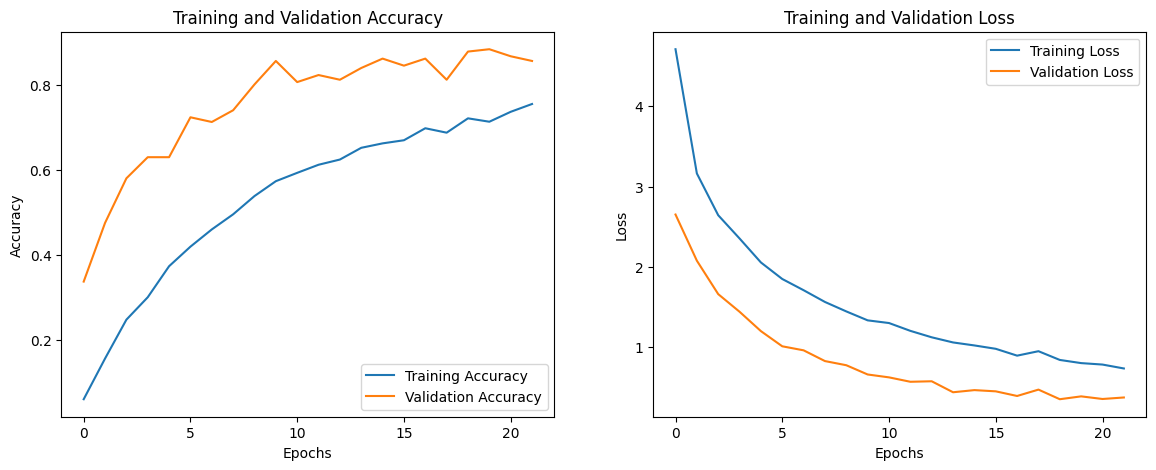

In [15]:
import time
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import keras
import pickle
import numpy as np

# Use the best hyperparameters and epochs found from previous experiments
final_learning_rate = 0.001
final_weight_decay = 0.1
final_batch_size = 256
final_num_epochs = 25  # Replace with best epoch size found

# Initialize model
final_vit_classifier = create_traditional_vit_classifier()

# Count the total parameters in the model
total_params = final_vit_classifier.count_params()

# Set up early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
)

# Define checkpoint to save the best model based on validation accuracy
checkpoint_filepath = "/tmp/final_checkpoint.weights.h5"
checkpoint_callback = ModelCheckpoint(
    checkpoint_filepath,
    monitor="val_accuracy",
    save_best_only=True,
    save_weights_only=True
)

# Measure start time for training
train_start_time = time.time()

# Compile model with specified optimizer and settings
optimizer = keras.optimizers.AdamW(
    learning_rate=final_learning_rate,
    weight_decay=final_weight_decay
)

final_vit_classifier.compile(
    optimizer=optimizer,
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[
        keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
        keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
    ],
)

# Train the model with best parameters and store history
history = final_vit_classifier.fit(
    x=train_x,
    y=train_y,
    batch_size=final_batch_size,
    epochs=final_num_epochs,
    validation_split=0.1,
    callbacks=[early_stopping, checkpoint_callback]
)

# Measure end time and calculate total training runtime
train_end_time = time.time()
training_runtime = train_end_time - train_start_time

# Load the best model weights for final evaluation
final_vit_classifier.load_weights(checkpoint_filepath)

# Evaluate on the test set and collect metrics
eval_metrics = final_vit_classifier.evaluate(test_x, test_y)
test_loss, test_accuracy, test_top_5_accuracy = eval_metrics

# Measure inference time on a subset of test data
inference_start_time = time.time()
predictions = final_vit_classifier.predict(test_x[:100])  # Adjust batch size if needed
inference_end_time = time.time()
inference_runtime = (inference_end_time - inference_start_time) / 100  # Per-sample inference time

# Store all final results for comparison
final_results = {
    "learning_rate": final_learning_rate,
    "weight_decay": final_weight_decay,
    "batch_size": final_batch_size,
    "epochs": final_num_epochs,
    "total_params": total_params,
    "training_runtime": training_runtime,
    "test_loss": test_loss,
    "test_accuracy": test_accuracy,
    "test_top_5_accuracy": test_top_5_accuracy,
    "inference_time_per_sample": inference_runtime,
    "history": history.history  # includes loss and accuracy history
}

print(f"Final Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Final Test Top-5 Accuracy: {test_top_5_accuracy * 100:.2f}%")
print(f"Total Training Time: {training_runtime:.2f} seconds")
print(f"Inference Time per Sample: {inference_runtime:.5f} seconds")
print(f"Total Parameters: {total_params}")

# Save results for later use or comparison
with open("final_vit_results.pkl", "wb") as f:
    pickle.dump(final_results, f)

# Plotting accuracy and loss for final model
plt.figure(figsize=(14, 5))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(final_results["history"]["accuracy"], label="Training Accuracy")
plt.plot(final_results["history"]["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(final_results["history"]["loss"], label="Training Loss")
plt.plot(final_results["history"]["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

plt.show()

Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 45s 3s/step - accuracy: 0.0526 - loss: 4.9425 - top-5-accuracy: 0.2207 - val_accuracy: 0.3757 - val_loss: 2.3978 - val_top-5-accuracy: 0.7238
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 50s 4s/step - accuracy: 0.1850 - loss: 2.9748 - top-5-accuracy: 0.5219 - val_accuracy: 0.5912 - val_loss: 1.8160 - val_top-5-accuracy: 0.8950
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 51s 4s/step - accuracy: 0.2822 - loss: 2.4611 - top-5-accuracy: 0.6609 - val_accuracy: 0.6464 - val_loss: 1.4238 - val_top-5-accuracy: 0.9503
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 50s 4s/step - accuracy: 0.3610 - loss: 2.0734 - top-5-accuracy: 0.7746 - val_accuracy: 0.6519 - val_loss: 1.1391 - val_top-5-accuracy: 0.9503
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 50s 4s/step - accuracy: 0.4581 - loss: 1.8486 - top-5-accuracy: 0.8316 - val_accuracy: 0.6796 - val_loss: 1.0284 - val_top-5-accuracy: 0.9558
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 46s 4s/step - accuracy: 0.4704 - loss: 1.6703 - top-5-accuracy

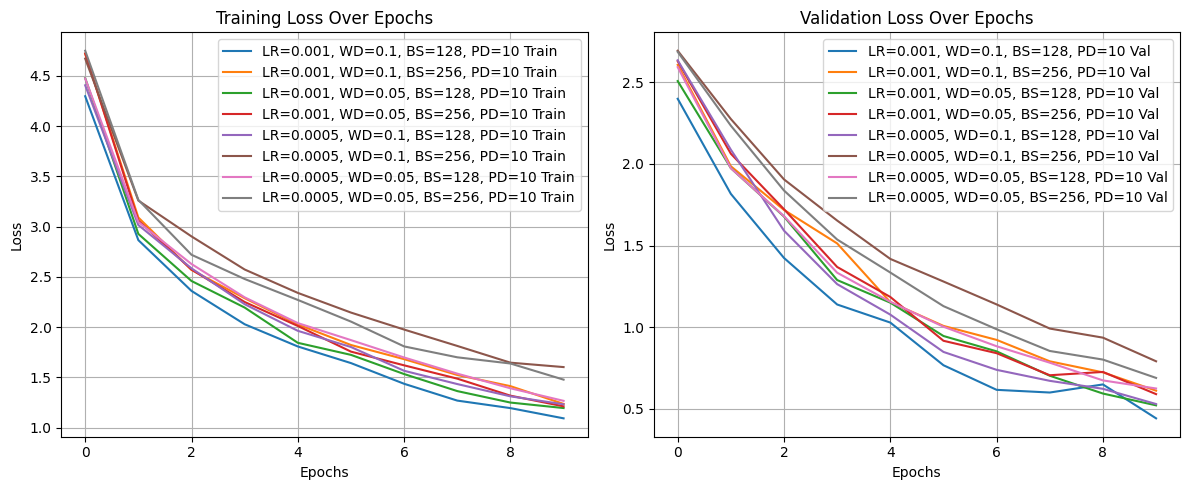

In [57]:
# Define hyperparameter ranges
learning_rates = [0.001, 0.0005]
weight_decays = [0.1, 0.05]
batch_sizes = [128, 256]
epoch_options = [10]  

# Store results for comparison
results_convo = []

for lr in learning_rates:
    for wd in weight_decays:
        for bs in batch_sizes:
            for num_epochs in epoch_options:
                # Initialize model
                vit_ConvolutionalAdditiveAttention_classifier = create_ConvolutionalAdditiveAttention_vit_classifier()
                
                # Measure start time
                start_time = time.time()
                
                # Run experiment
                history2 = run_experiment(
                    vit_ConvolutionalAdditiveAttention_classifier,
                    learning_rate=lr,
                    weight_decay=wd,
                    batch_size=bs,
                    num_epochs=num_epochs
                )
                
                # Measure end time and calculate runtime
                end_time = time.time()
                runtime = end_time - start_time
                
                # Collect results
                results_convo.append({
                    "params": (lr, wd, bs, num_epochs),
                    "history": history2,
                    "runtime": runtime
                })

# Example of how to plot results
plot_comparison(results_convo, "loss")  # Replace "loss" with other metrics as needed

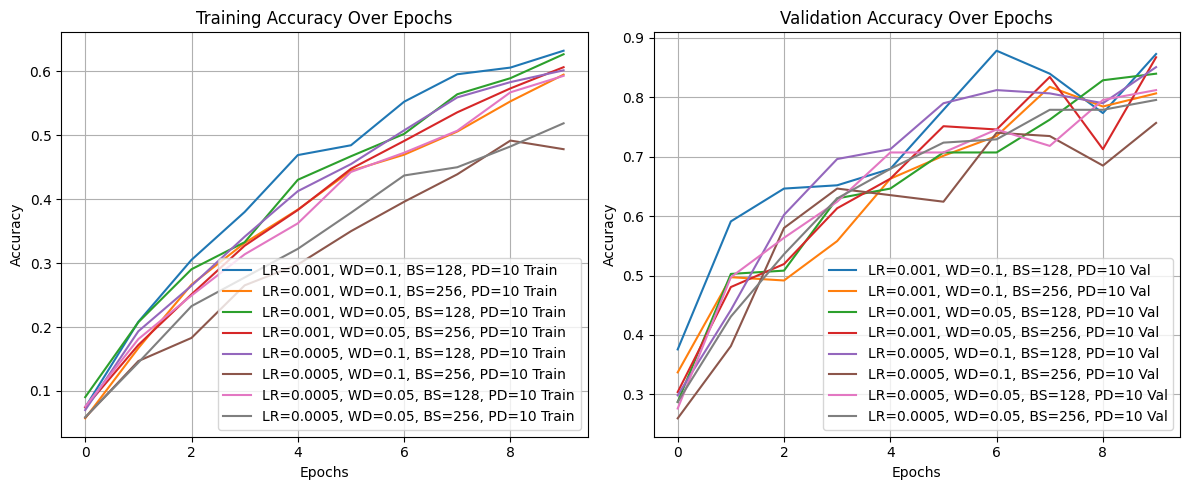

In [58]:
plot_comparison(results_convo, "accuracy")  # Replace "loss" with other metrics as needed

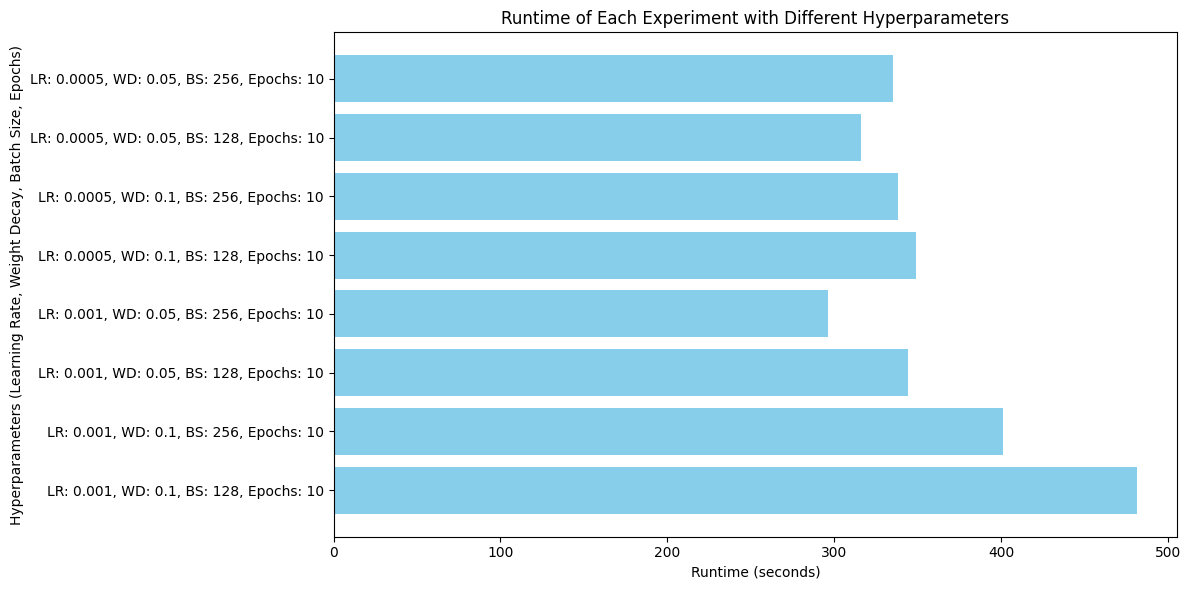

In [59]:
import matplotlib.pyplot as plt

# Extract parameters and runtimes from results
params = [f"LR: {r['params'][0]}, WD: {r['params'][1]}, BS: {r['params'][2]}, Epochs: {r['params'][3]}"
          for r in results_convo]
runtimes = [r['runtime'] for r in results_convo]

# Create a bar plot for runtime
plt.figure(figsize=(12, 6))
plt.barh(params, runtimes, color='skyblue')
plt.xlabel("Runtime (seconds)")
plt.ylabel("Hyperparameters (Learning Rate, Weight Decay, Batch Size, Epochs)")
plt.title("Runtime of Each Experiment with Different Hyperparameters")
plt.tight_layout()
plt.show()

Epoch 1/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 65s 8s/step - accuracy: 0.0511 - loss: 5.0965 - top-5-accuracy: 0.2125 - val_accuracy: 0.3481 - val_loss: 2.5109 - val_top-5-accuracy: 0.7514
Epoch 2/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 40s 6s/step - accuracy: 0.1510 - loss: 3.1473 - top-5-accuracy: 0.4634 - val_accuracy: 0.4917 - val_loss: 1.9405 - val_top-5-accuracy: 0.8729
Epoch 3/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 39s 6s/step - accuracy: 0.2531 - loss: 2.5968 - top-5-accuracy: 0.6119 - val_accuracy: 0.5580 - val_loss: 1.6339 - val_top-5-accuracy: 0.9061
Epoch 4/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 39s 6s/step - accuracy: 0.3174 - loss: 2.2784 - top-5-accuracy: 0.7138 - val_accuracy: 0.6409 - val_loss: 1.3344 - val_top-5-accuracy: 0.9558
Epoch 5/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 40s 6s/step - accuracy: 0.3881 - loss: 1.9714 - top-5-accuracy: 0.8079 - val_accuracy: 0.6796 - val_loss: 1.0752 - val_top-5-accuracy: 0.9613
Epoch 6/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 39s 6s/step - accuracy: 0.4376 - loss: 1.8243 - top-5-accuracy: 0.8179 - v

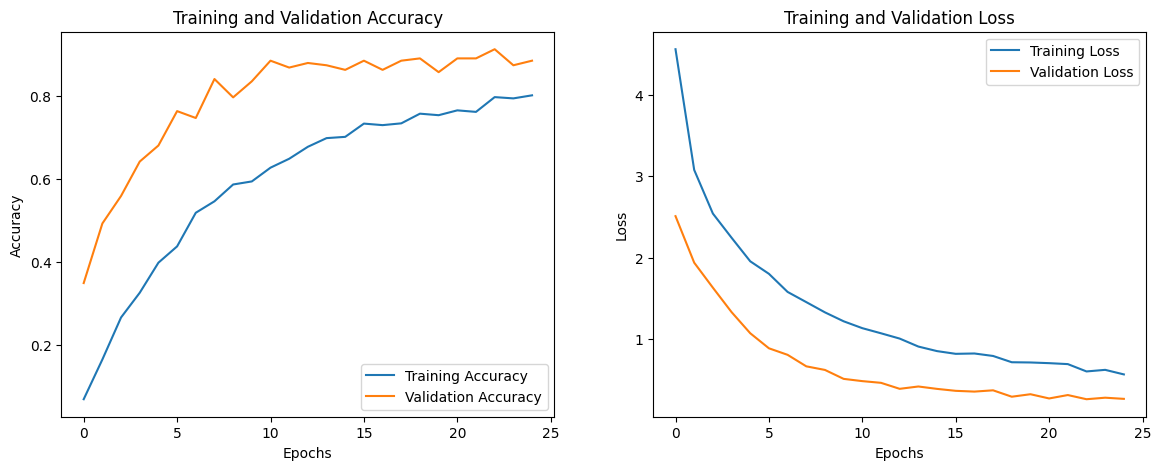

In [24]:
import time
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import keras
import pickle
import numpy as np

# Use the best hyperparameters and epochs found from previous experiments
final_learning_rate = 0.001
final_weight_decay = 0.05
final_batch_size = 256
final_num_epochs = 25  # Replace with best epoch size found

# Initialize model
final_Con_vit_classifier = create_ConvolutionalAdditiveAttention_vit_classifier()

# Count the total parameters in the model
total_params = final_Con_vit_classifier.count_params()

# Set up early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
)

# Define checkpoint to save the best model based on validation accuracy
checkpoint_filepath = "/tmp/final_checkpoint.weights.h5"
checkpoint_callback = ModelCheckpoint(
    checkpoint_filepath,
    monitor="val_accuracy",
    save_best_only=True,
    save_weights_only=True
)

# Measure start time for training
train_start_time = time.time()

# Compile model with specified optimizer and settings
optimizer = keras.optimizers.AdamW(
    learning_rate=final_learning_rate,
    weight_decay=final_weight_decay
)

final_Con_vit_classifier.compile(
    optimizer=optimizer,
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[
        keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
        keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
    ],
)

# Train the model with best parameters and store history
history = final_Con_vit_classifier.fit(
    x=train_x,
    y=train_y,
    batch_size=final_batch_size,
    epochs=final_num_epochs,
    validation_split=0.1,
    callbacks=[early_stopping, checkpoint_callback]
)

# Measure end time and calculate total training runtime
train_end_time = time.time()
training_runtime = train_end_time - train_start_time

# Load the best model weights for final evaluation
final_Con_vit_classifier.load_weights(checkpoint_filepath)

# Evaluate on the test set and collect metrics
eval_metrics = final_Con_vit_classifier.evaluate(test_x, test_y)
test_loss, test_accuracy, test_top_5_accuracy = eval_metrics

# Measure inference time on a subset of test data
inference_start_time = time.time()
predictions = final_Con_vit_classifier.predict(test_x[:100])  # Adjust batch size if needed
inference_end_time = time.time()
inference_runtime = (inference_end_time - inference_start_time) / 100  # Per-sample inference time

# Store all final results for comparison
final_results2 = {
    "learning_rate": final_learning_rate,
    "weight_decay": final_weight_decay,
    "batch_size": final_batch_size,
    "epochs": final_num_epochs,
    "total_params": total_params,
    "training_runtime": training_runtime,
    "test_loss": test_loss,
    "test_accuracy": test_accuracy,
    "test_top_5_accuracy": test_top_5_accuracy,
    "inference_time_per_sample": inference_runtime,
    "history": history.history  # includes loss and accuracy history
}

print(f"Final Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Final Test Top-5 Accuracy: {test_top_5_accuracy * 100:.2f}%")
print(f"Total Training Time: {training_runtime:.2f} seconds")
print(f"Inference Time per Sample: {inference_runtime:.5f} seconds")
print(f"Total Parameters: {total_params}")

# Save results for later use or comparison
with open("final_vit_results.pkl", "wb") as f:
    pickle.dump(final_results2, f)

# Plotting accuracy and loss for final model
plt.figure(figsize=(14, 5))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(final_results2["history"]["accuracy"], label="Training Accuracy")
plt.plot(final_results2["history"]["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(final_results2["history"]["loss"], label="Training Loss")
plt.plot(final_results2["history"]["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

plt.show()

In [26]:
# Save the final model for later use
# Save the model in SavedModel format
final_Con_vit_classifier.save("saved_model.keras", save_format="tf")

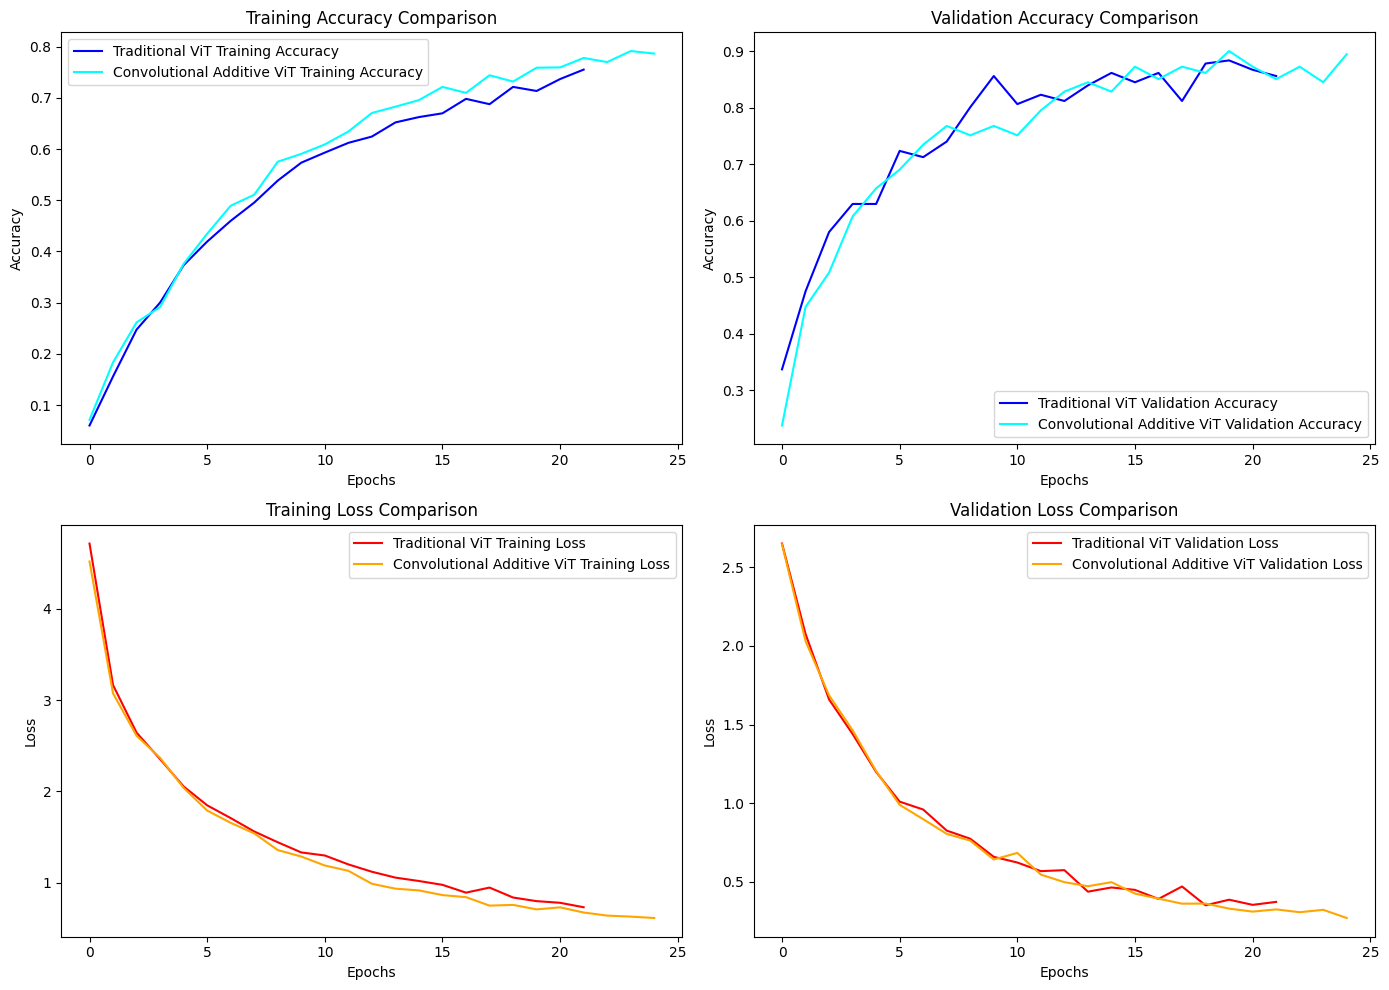

In [22]:
import matplotlib.pyplot as plt

# Extract histories for both models
history_traditional_vit = final_results["history"]
history_conv_additive_vit = final_results2["history"]

# Define figure size and layout for four subplots
plt.figure(figsize=(14, 10))

# Plot training accuracy for both models
plt.subplot(2, 2, 1)
plt.plot(history_traditional_vit["accuracy"], label="Traditional ViT Training Accuracy", color="blue")
plt.plot(history_conv_additive_vit["accuracy"], label="Convolutional Additive ViT Training Accuracy", color="cyan")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy Comparison")
plt.legend()

# Plot validation accuracy for both models
plt.subplot(2, 2, 2)
plt.plot(history_traditional_vit["val_accuracy"], label="Traditional ViT Validation Accuracy", color="blue")
plt.plot(history_conv_additive_vit["val_accuracy"], label="Convolutional Additive ViT Validation Accuracy", color="cyan")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy Comparison")
plt.legend()

# Plot training loss for both models
plt.subplot(2, 2, 3)
plt.plot(history_traditional_vit["loss"], label="Traditional ViT Training Loss", color="red")
plt.plot(history_conv_additive_vit["loss"], label="Convolutional Additive ViT Training Loss", color="orange")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Comparison")
plt.legend()

# Plot validation loss for both models
plt.subplot(2, 2, 4)
plt.plot(history_traditional_vit["val_loss"], label="Traditional ViT Validation Loss", color="red")
plt.plot(history_conv_additive_vit["val_loss"], label="Convolutional Additive ViT Validation Loss", color="orange")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Validation Loss Comparison")
plt.legend()

# Show the plot with all subplots
plt.tight_layout()
plt.show()

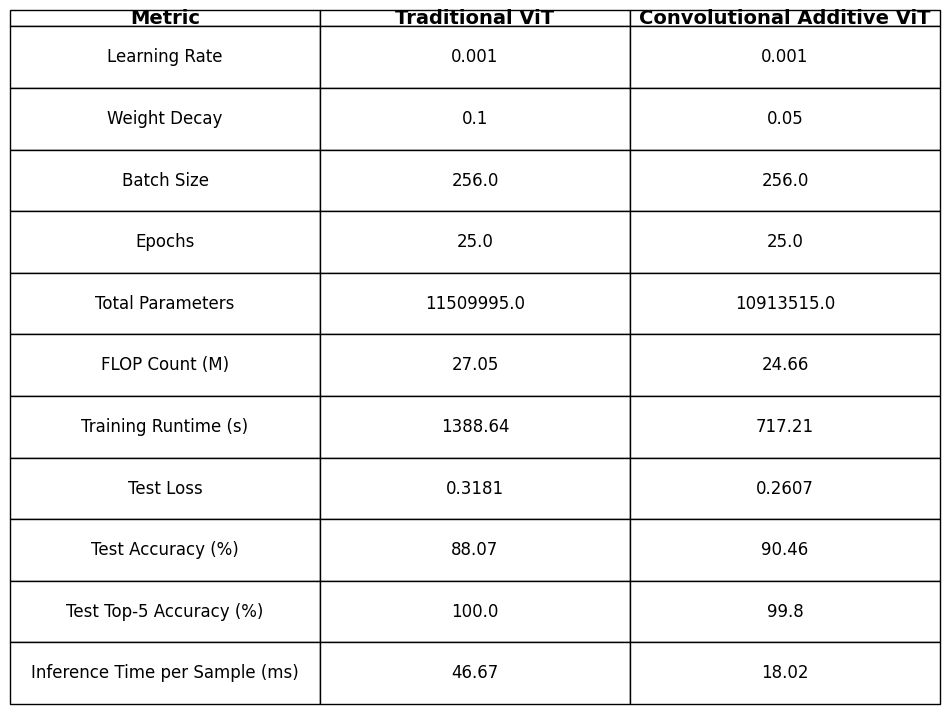

In [99]:
import pandas as pd
import matplotlib.pyplot as plt

# Define the metrics for comparison
comparison_data = {
    "Metric": [
        "Learning Rate",
        "Weight Decay",
        "Batch Size",
        "Epochs",
        "Total Parameters",
        "FLOP Count (M)",
        "Training Runtime (s)",
        "Test Loss",
        "Test Accuracy (%)",
        "Test Top-5 Accuracy (%)",
        "Inference Time per Sample (ms)"
    ],
    "Traditional ViT": [
        final_results["learning_rate"],
        final_results["weight_decay"],
        final_results["batch_size"],
        final_results["epochs"],
        final_results["total_params"],
        round(mha_flops_count / 1000000, 2),  # Replace with your actual FLOP count
        round(final_results["training_runtime"], 2),
        round(final_results["test_loss"], 4),
        round(final_results["test_accuracy"] * 100, 2),
        round(final_results["test_top_5_accuracy"] * 100, 2),
        round(final_results["inference_time_per_sample"] * 1000, 2)  # Convert to ms
    ],
    "Convolutional Additive ViT": [
        final_results2["learning_rate"],
        final_results2["weight_decay"],
        final_results2["batch_size"],
        final_results2["epochs"],
        final_results2["total_params"],
        round(cat_flops_count / 1000000, 2),  # Replace with your actual FLOP count
        round(final_results2["training_runtime"], 2),
        round(final_results2["test_loss"], 4),
        round(final_results2["test_accuracy"] * 100, 2),
        round(final_results2["test_top_5_accuracy"] * 100, 2),
        round(final_results2["inference_time_per_sample"] * 1000, 2)  # Convert to ms
    ]
}

# Create a DataFrame
df_comparison = pd.DataFrame(comparison_data)

# Plot the DataFrame as a table with custom styling
fig, ax = plt.subplots(figsize=(12, 8))
ax.axis('tight')
ax.axis('off')

# Create the table
table = ax.table(cellText=df_comparison.values, colLabels=df_comparison.columns, cellLoc='center', loc='center')

# Adjust font size
table.auto_set_font_size(False)
table.set_fontsize(12)

# Set row height for spacing
for key, cell in table.get_celld().items():
    if key[0] == 0:  # Header row
        cell.set_fontsize(14)  # Make header larger
        cell.set_text_props(weight='bold')
    else:
        cell.set_height(0.1)  # Adjust this value for more/less spacing

plt.show()

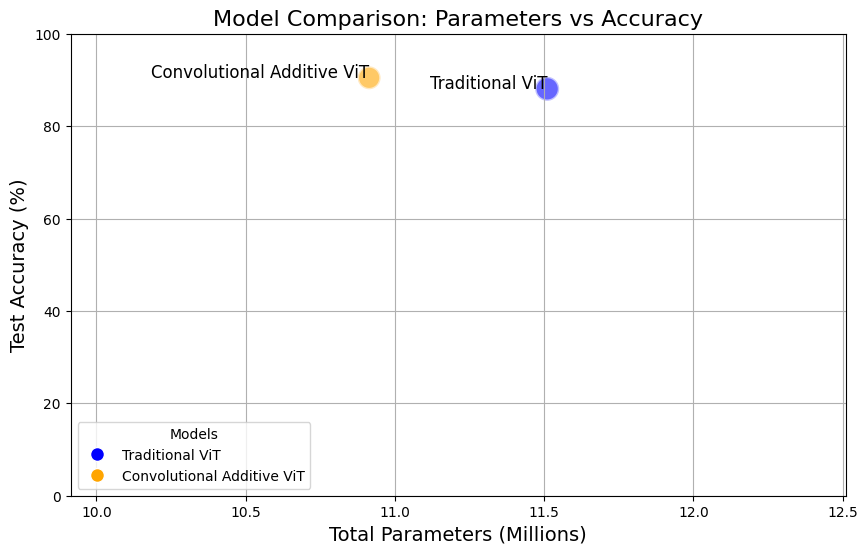

In [106]:
import matplotlib.pyplot as plt

# Data for the two models
models = ['Traditional ViT', 'Convolutional Additive ViT']
param_sizes = [final_results['total_params'] / 1_000_000, final_results2['total_params'] / 1_000_000]  # Convert to millions
accuracies = [final_results['test_accuracy'] * 100, final_results2['test_accuracy'] * 100]  # Test Accuracy (%)
flops = [mha_flops_count, cat_flops_count]  # FLOP counts (ensure these are defined)


# Create the bubble chart
plt.figure(figsize=(10, 6))

# Use a fixed size scale to ensure both bubbles are distinguishable
fixed_scale = 300  # Adjust this scale as necessary
scatter = plt.scatter(param_sizes, accuracies, s=[flop / max_flops * fixed_scale for flop in flops], 
                       alpha=0.6, c=['blue', 'orange'], edgecolors='w', linewidth=2)

# Add labels and title
plt.title('Model Comparison: Parameters vs Accuracy', fontsize=16)
plt.xlabel('Total Parameters (Millions)', fontsize=14)
plt.ylabel('Test Accuracy (%)', fontsize=14)

# Set the x-axis limits to center the bubbles
plt.xlim(min(param_sizes) - 1, max(param_sizes) + 1)  # Add some padding

# Set the y-axis limits to range from 0 to 100
plt.ylim(0, 100)

# Annotate points with model names
for i, model in enumerate(models):
    plt.annotate(model, (param_sizes[i], accuracies[i]), fontsize=12, ha='right')

# Create a legend for bubble colors
colors = ['blue', 'orange']
labels = models
handles = [plt.Line2D([0], [0], marker='o', color='w', label=label, 
                       markerfacecolor=color, markersize=10) for label, color in zip(labels, colors)]
plt.legend(handles=handles, title='Models', loc='lower left')

# Show plot
plt.grid(True)
plt.show()

In [17]:
# Example class names list (update with actual class names)
class_mapping = {i: label for i, label in enumerate(class_names)}

In [18]:
# Assuming `validation_data` is the data you want to evaluate on
y_true = test_y # Replace with actual labels of your validation/test set
y_pred = final_vit_classifier.predict(test_x)

# Convert predicted probabilities to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert numeric labels to real class labels
y_true_labels = [class_mapping[label] for label in y_true]
y_pred_labels = [class_mapping[label] for label in y_pred_classes]

16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 268ms/step


Classification Report:
              precision    recall  f1-score   support

           0     0.9000    0.9000    0.9000        10
           1     0.8824    1.0000    0.9375        15
           2     0.6522    0.9375    0.7692        16
           3     0.9375    0.8824    0.9091        17
           4     0.8750    0.7778    0.8235         9
           5     0.9231    0.9231    0.9231        13
           6     0.7143    0.2941    0.4167        17
           7     1.0000    0.8947    0.9444        19
           8     0.8889    0.9412    0.9143        17
           9     1.0000    0.8571    0.9231        14
           a     1.0000    0.9000    0.9474        10
           b     0.9167    1.0000    0.9565        11
           c     1.0000    0.9375    0.9677        16
           d     0.8571    0.8000    0.8276        15
           e     1.0000    1.0000    1.0000        13
           f     0.9412    0.9412    0.9412        17
           g     1.0000    0.9231    0.9600        13
    

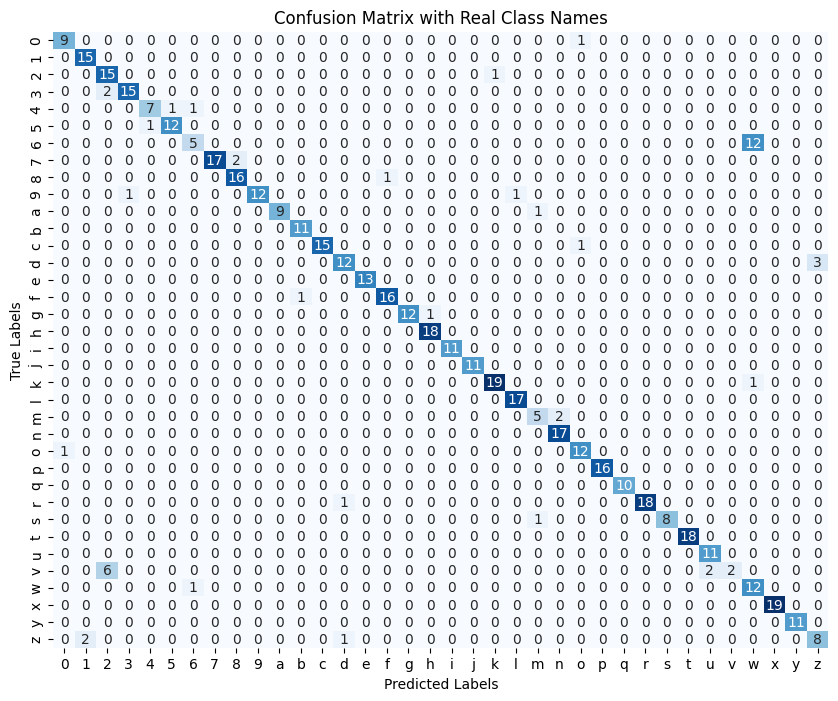

In [19]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels, labels=class_names)

# Full Classification Report
report = classification_report(y_true_labels, y_pred_labels, target_names=class_names, digits=4)
print("Classification Report:")
print(report)  # This should print the entire report

# Plot confusion matrix with real labels
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix with Real Class Names")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [20]:
# Assuming `validation_data` is the data you want to evaluate on
y_true = test_y # Replace with actual labels of your validation/test set
y_pred = final_Con_vit_classifier.predict(test_x)

# Convert predicted probabilities to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert numeric labels to real class labels
y_true_labels = [class_mapping[label] for label in y_true]
y_pred_labels = [class_mapping[label] for label in y_pred_classes]

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 151ms/step


Classification Report:
              precision    recall  f1-score   support

           0     1.0000    0.8000    0.8889        10
           1     1.0000    0.9333    0.9655        15
           2     1.0000    0.7500    0.8571        16
           3     1.0000    0.8824    0.9375        17
           4     0.8750    0.7778    0.8235         9
           5     0.9231    0.9231    0.9231        13
           6     0.7273    0.4706    0.5714        17
           7     0.9444    0.8947    0.9189        19
           8     0.8947    1.0000    0.9444        17
           9     0.8667    0.9286    0.8966        14
           a     0.7143    1.0000    0.8333        10
           b     0.8462    1.0000    0.9167        11
           c     1.0000    1.0000    1.0000        16
           d     1.0000    0.7333    0.8462        15
           e     1.0000    1.0000    1.0000        13
           f     1.0000    0.8824    0.9375        17
           g     1.0000    0.4615    0.6316        13
    

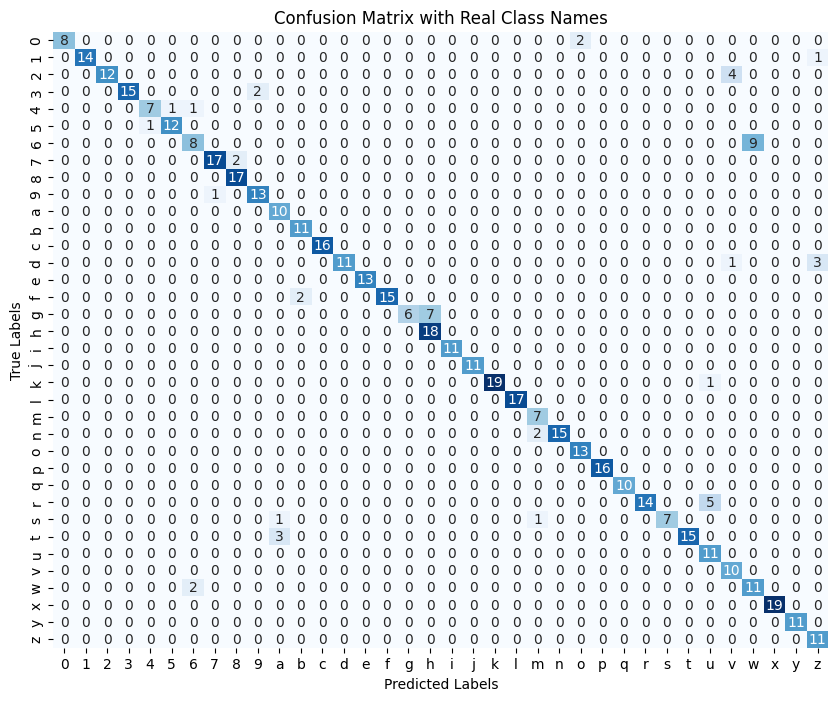

In [21]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels, labels=class_names)

# Full Classification Report
report = classification_report(y_true_labels, y_pred_labels, target_names=class_names, digits=4)
print("Classification Report:")
print(report)  # This should print the entire report

# Plot confusion matrix with real labels
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix with Real Class Names")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()